In [1]:
import os
import sys

top_dir = os.path.split(os.getcwd())[0]
sys.path.append(top_dir)
sys.path.append(os.path.join(top_dir, "src"))

In [2]:
import numpy as np
import pretty_midi
from glob import glob
import scipy.signal
import scipy.spatial.distance
import matplotlib.pyplot as plt

# Content Preservation

In [3]:
def _as_note_list(sequence):
    if isinstance(sequence, pretty_midi.PrettyMIDI):
        sequence = [note for instrument in sequence.instruments for note in instrument.notes]

    return sequence


def _strip_velocity(notes):
    return [pretty_midi.Note(pitch=n.pitch, start=n.start, end=n.end, velocity=127)
            for n in notes]


def _get_chroma(notes, sampling_rate):
    midi = pretty_midi.Instrument(0) # Grand Piano
    midi.notes[:] = notes
    return midi.get_chroma(fs=sampling_rate)


def _average_cos_similarity(chroma_a, chroma_b):
    """Compute the column-wise cosine similarity, averaged over all non-zero columns."""
    nonzero_cols_ab = []
    for chroma in (chroma_a, chroma_b):
        col_norms = np.linalg.norm(chroma, axis=0)
        nonzero_cols = col_norms > 1e-9
        nonzero_cols_ab.append(nonzero_cols)
        # Note: 'np.divide' needs the 'out' parameter, otherwise the output would get written to
        # an uninitialized array.
        np.divide(chroma, col_norms, where=nonzero_cols, out=chroma)

    # Count the columns where at least one of the two matrices is nonzero.
    num_nonzero_cols = np.logical_or(*nonzero_cols_ab).sum()  # pylint: disable=no-value-for-parameter

    # Compute the dot product.
    return np.tensordot(chroma_a, chroma_b) / num_nonzero_cols


def _convolve_strided(data, filtr, stride):
    """Compute a 2D convolution with the given stride along the second dimension.
    A full (zero-padded) 2D convolution is computed, then subsampled according to the stride with
    an offset calculated so that the convolution window is aligned to the left edge of the original
    array.
    """
    convolution = scipy.signal.convolve2d(data, filtr, mode='full')
    offset = (filtr.shape[-1] - 1) % stride  # Make sure the windows are aligned
    return convolution[:, offset::stride]

In [4]:
def chroma_similarity(sequence_a, sequence_b, sampling_rate, window_size, stride,
                      use_velocity=False):
    notes_a, notes_b = (_as_note_list(seq) for seq in (sequence_a, sequence_b))

    if not use_velocity:
        notes_a, notes_b = (_strip_velocity(notes) for notes in (notes_a, notes_b))

    chroma_a, chroma_b = (_get_chroma(notes, sampling_rate) for notes in (notes_a, notes_b))

    # Make sure the chroma matrices have the same dimensions.
    if chroma_a.shape[1] < chroma_b.shape[1]:
        chroma_a, chroma_b = chroma_b, chroma_a
    chroma_b = np.pad(chroma_b, [(0, 0), (0, chroma_a.shape[1] - chroma_b.shape[1])],
                      mode='constant')

    # Compute a moving average over time.
    avg_filter = np.ones((1, window_size)) / window_size
    chroma_avg_a, chroma_avg_b = (_convolve_strided(chroma, avg_filter, stride)
                                  for chroma in (chroma_a, chroma_b))

    return _average_cos_similarity(chroma_avg_a, chroma_avg_b), (chroma_a, chroma_avg_a, chroma_b, chroma_avg_b)

In [5]:
# Change this path to the path of the converted songs
fpaths = glob("../converted/CP_C2CP_P_30e_bs32_nr84_ts64_sd1_run_2022_06_25-19_24_32/A2B/*.mid*")

cycled_fpaths = fpaths[::3]
original_fpaths = fpaths[1::3]
transfer_fpaths = fpaths[2::3]

cycled_names = [os.path.split(fpath)[-1] for fpath in cycled_fpaths]
original_names = [os.path.split(fpath)[-1] for fpath in original_fpaths]
transfer_names = [os.path.split(fpath)[-1] for fpath in transfer_fpaths]

cycled_songs = [pretty_midi.PrettyMIDI(filepath) for filepath in cycled_fpaths]
original_songs = [pretty_midi.PrettyMIDI(filepath) for filepath in original_fpaths]
transfer_songs = [pretty_midi.PrettyMIDI(filepath) for filepath in transfer_fpaths]

len(cycled_songs) == len(cycled_fpaths)

True

In [6]:
similarity, _ = chroma_similarity(original_songs[0], transfer_songs[0], sampling_rate=16, window_size=12, stride=1)
similarity

0.7004662095250198

Crude plot of all the preservation metrics

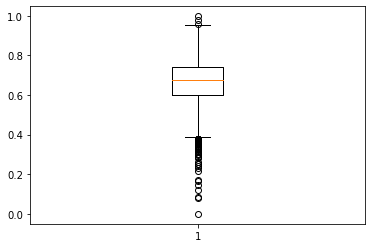

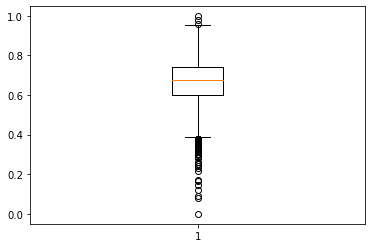

In [7]:
sampling_rate = 12
window_size = 24
stride = 12
use_velocity = False

similarity_ot = []
similarity_oc = []
for orig, transfer, cycle in zip(original_songs, transfer_songs, cycled_songs):
    sim_ot, _ = chroma_similarity(orig, transfer, sampling_rate=sampling_rate, window_size=window_size, stride=stride)
    sim_oc, _ = chroma_similarity(orig, cycle, sampling_rate=sampling_rate, window_size=window_size, stride=stride)
    similarity_ot.append(sim_ot)
    similarity_oc.append(sim_oc)

plt.boxplot(similarity_ot)
plt.show()
plt.boxplot(similarity_oc)
plt.show()
    

-----

In [8]:
idx = 10
song_a = original_songs[idx]
song_b = transfer_songs[idx]
song_c = cycled_songs[idx]

print(f"Comparing {original_names[idx]} and {transfer_names[idx]} and {cycled_names[idx]}")



sim_ab, (chroma_a, chroma_avg_a, chroma_b, chroma_avg_b) = chroma_similarity(song_a, song_b, sampling_rate=sampling_rate, window_size=window_size, stride=stride)
sim_ac, (_, _, chroma_c, chroma_avg_c) = chroma_similarity(song_a, song_c, sampling_rate=sampling_rate, window_size=window_size, stride=stride)

Comparing 1009_original.mid and 1009_transfer.mid and 1009_cycle.mid


Here's how the convolution is computed and strided.

(12, 144) (1, 24) (12, 167) (12, 12)


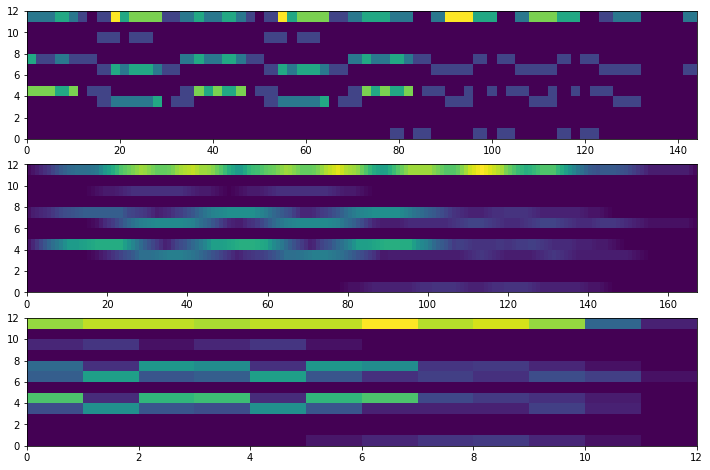

In [103]:
avg_filter = np.ones((1, window_size)) / window_size

convolved = scipy.signal.convolve2d(chroma_a, avg_filter)
offset = avg_filter.shape[-1] -1 % stride

strided = convolved[:, offset::stride]
print(chroma_a.shape, avg_filter.shape, convolved.shape, strided.shape)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 8))

ax1.pcolormesh(chroma_a)
ax2.pcolormesh(convolved)
ax3.pcolormesh(strided)

plt.show()

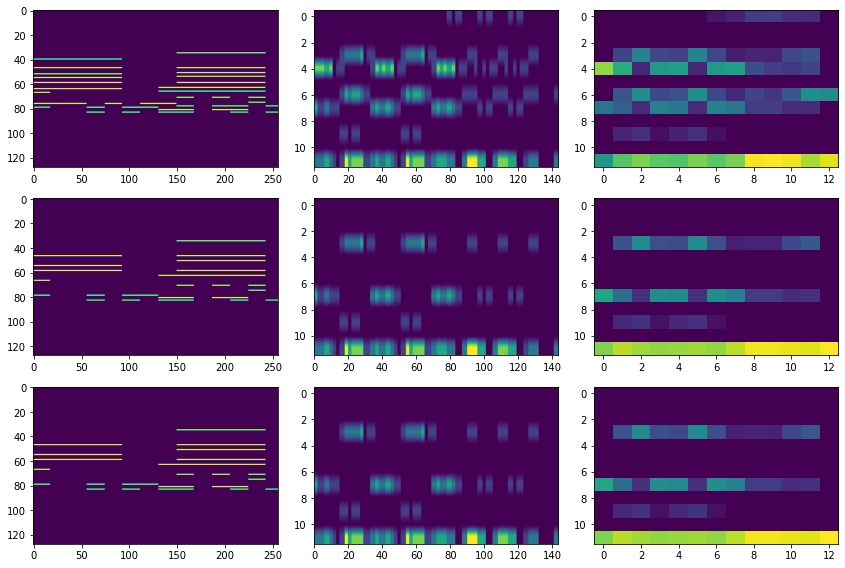

Similarity Original - Transfer = 85.080%
Similarity Original - Cycled = 85.080%


In [9]:
max_notes = 256

fig, (ax1, ax2, ax3) = plt.subplots(3, 3, figsize=(12, 8))

ax1[0].imshow(song_a.get_piano_roll()[:, :max_notes], aspect="auto")
ax1[1].imshow(chroma_a[:, :max_notes], aspect="auto")
ax1[2].imshow(chroma_avg_a[:, :max_notes], aspect="auto")

ax2[0].imshow(song_b.get_piano_roll()[:, :max_notes], aspect="auto")
ax2[1].imshow(chroma_b[:, :max_notes], aspect="auto")
ax2[2].imshow(chroma_avg_b[:, :max_notes], aspect="auto")

ax3[0].imshow(song_c.get_piano_roll()[:, :max_notes], aspect="auto")
ax3[1].imshow(chroma_c[:, :max_notes], aspect="auto")
ax3[2].imshow(chroma_avg_c[:, :max_notes], aspect="auto")

fig.tight_layout()
plt.show()

print(f"Similarity Original - Transfer = {sim_ab:.3%}")
print(f"Similarity Original - Cycled = {sim_ac:.3%}")

--- 


# Style Preservation

Code from the original paper  `Supervised Symbolic Music Style transfer ... ` from Cifka et al.

In [10]:
# This is the function used to load the data
# Ref to `normalize_tempo`: https://github.com/cifkao/museflow/blob/master/museflow/scripts/chop_midi.py#L120
def get_data():
    for path in args.midi_paths:
        midi = pretty_midi.PrettyMIDI(path)
        normalize_tempo(midi, 60)
        yield [note for instr in midi.instruments for note in instr.notes]

def time_pitch_diff_hist(data, max_time=2, bin_size=1/6, pitch_range=20, normed=False):
    """Compute an onset-time-difference vs. interval histogram.
    Args:
        data: A list of lists of `pretty_midi.Note`.
        max_time: The maximum time between two notes to be considered.
        bin_size: The bin size along the time axis.
        pitch_range: The number of pitch difference bins in each direction (positive or negative,
            excluding 0). Each bin has size 1.
        normed: Whether to normalize the histogram.
    Returns:
        A 2D `np.array` of shape `[max_time / bin_size, 2 * pitch_range + 1]`.
    """
    epsilon = 1e-9
    time_diffs = []
    intervals = []
    for notes in data:
        onsets = [n.start for n in notes]
        diff_mat = np.subtract.outer(onsets, onsets)

        # Count only positive time differences.
        index_pairs = zip(*np.where((diff_mat < max_time - epsilon) & (diff_mat >= 0.)))
        for j, i in index_pairs:
            if j == i:
                continue

            time_diffs.append(diff_mat[j, i])
            intervals.append(notes[j].pitch - notes[i].pitch)

    histogram, _, _ = np.histogram2d(intervals, time_diffs, normed=normed,
                                     bins=[np.arange(-(pitch_range + 1), pitch_range + 1) + 0.5,
                                           np.arange(0., max_time + bin_size - epsilon, bin_size)])
    np.nan_to_num(histogram, copy=False)                           
    return histogram

#### Breaking this code down

In [11]:
eps = 1e-9 
max_time = 4
bin_size = 1/6
pitch_range = 20
normed = False
time_diffs = []
intervals = []

midi = original_songs[5]
data = [note for instr in midi.instruments for note in instr.notes]
len(midi.instruments), len(data)

(1, 110)

In [12]:
for notes in [data[:10]]:
    onsets = [n.start for n in notes]
onsets

[0.0, 0.1875, 0.1875, 0.375, 0.375, 0.5625, 0.5625, 0.75, 0.0, 0.9375]

In [13]:
diff_mat = np.subtract.outer(onsets, onsets)
diff_mat[:3]

array([[ 0.    , -0.1875, -0.1875, -0.375 , -0.375 , -0.5625, -0.5625,
        -0.75  ,  0.    , -0.9375],
       [ 0.1875,  0.    ,  0.    , -0.1875, -0.1875, -0.375 , -0.375 ,
        -0.5625,  0.1875, -0.75  ],
       [ 0.1875,  0.    ,  0.    , -0.1875, -0.1875, -0.375 , -0.375 ,
        -0.5625,  0.1875, -0.75  ]])

In [14]:
index_pairs = zip(*np.where((diff_mat < max_time - eps) & (diff_mat >= 0.)))
print(list(index_pairs))
index_pairs = zip(*np.where((diff_mat < max_time - eps) & (diff_mat >= 0.)))


[(0, 0), (0, 8), (1, 0), (1, 1), (1, 2), (1, 8), (2, 0), (2, 1), (2, 2), (2, 8), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 8), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 8), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 8), (6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 8), (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7), (7, 8), (8, 0), (8, 8), (9, 0), (9, 1), (9, 2), (9, 3), (9, 4), (9, 5), (9, 6), (9, 7), (9, 8), (9, 9)]


In [15]:
for j, i in index_pairs:
    if j == i:
        continue

    time_diffs.append(diff_mat[j, i]) # Where the differences are > 0 
    intervals.append(notes[j].pitch - notes[i].pitch) # The pitch differences

In [16]:
list(zip(time_diffs, intervals))[:5]

[(0.0, -12), (0.1875, 16), (0.0, -8), (0.1875, 4), (0.1875, 24)]

The list above shows the onset where there is a pitch difference and the value of the pitch difference. We can reference this to the list `index_pairs` (excluding entries where the indices are the same) and look at the notes in the data to ensure the values are calculated correctly.

For example. The first value is `(0.0, -12)` and the corresponding index is `(0, 8)`. This means that the first and ninth note start at index 0 and have a difference of 12 semitones. We can verify this below

In [17]:
data[0], data[8]

(Note(start=0.000000, end=0.375000, pitch=43, velocity=100),
 Note(start=0.000000, end=1.125000, pitch=55, velocity=100))

In [18]:
bins_pitch = np.arange(-(pitch_range + 1), pitch_range + 1) + 0.5
bins_pitch

array([-20.5, -19.5, -18.5, -17.5, -16.5, -15.5, -14.5, -13.5, -12.5,
       -11.5, -10.5,  -9.5,  -8.5,  -7.5,  -6.5,  -5.5,  -4.5,  -3.5,
        -2.5,  -1.5,  -0.5,   0.5,   1.5,   2.5,   3.5,   4.5,   5.5,
         6.5,   7.5,   8.5,   9.5,  10.5,  11.5,  12.5,  13.5,  14.5,
        15.5,  16.5,  17.5,  18.5,  19.5,  20.5])

In [19]:
bins_interval = np.arange(0., max_time + bin_size - eps, bin_size)
bins_interval


array([0.        , 0.16666667, 0.33333333, 0.5       , 0.66666667,
       0.83333333, 1.        , 1.16666667, 1.33333333, 1.5       ,
       1.66666667, 1.83333333, 2.        , 2.16666667, 2.33333333,
       2.5       , 2.66666667, 2.83333333, 3.        , 3.16666667,
       3.33333333, 3.5       , 3.66666667, 3.83333333, 4.        ])

(41, 24)

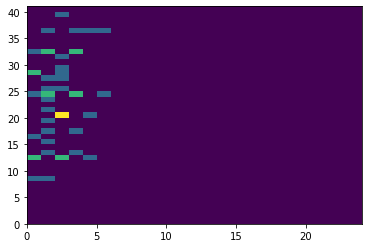

In [20]:
histogram, xedges, yedges = np.histogram2d(intervals, time_diffs, normed=normed, bins=[bins_pitch,bins_interval])
plt.pcolormesh(histogram)
histogram.shape

In [21]:
histogram.flatten().shape

(984,)

### Aggregating into a single style

The code does not give any indication as to how the reference styles in [this page](https://github.com/cifkao/ismir2019-music-style-translation/blob/75745ca38e9a7e74eca2a6208eb85f36f1776c80/data/parallel/style_profiles/Bass/DANCE_2.json) are computed. My best guess is that it is an average 

For the original songs

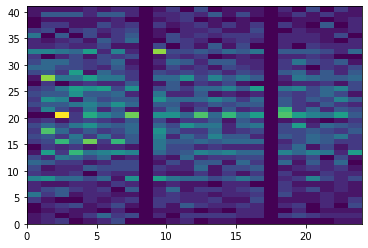

In [22]:
original_hists = []
for song  in original_songs:
    notes = [note for instr in midi.instruments for note in instr.notes]
    original_hists.append(time_pitch_diff_hist([notes], max_time=4, bin_size = 1/6, normed=True))
original_hists = np.array(original_hists)

orig_mean_hist = original_hists.mean(axis=0)
plt.pcolormesh(orig_mean_hist)

plt.show()

For the transferred songs

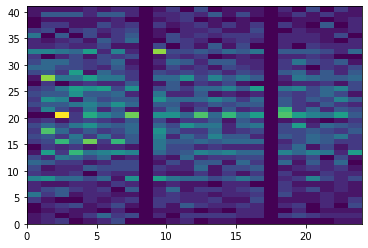

In [23]:
transfer_hists = []
for song  in transfer_songs:
    notes = [note for instr in midi.instruments for note in instr.notes]
    transfer_hists.append(time_pitch_diff_hist([notes], max_time=4, bin_size = 1/6, normed=True))
transfer_hists = np.array(transfer_hists)

transfer_mean_hist = transfer_hists.mean(axis=0)
plt.pcolormesh(transfer_mean_hist)

plt.show()

THis is comparing the transferred (C -> P) songs to the original profile (C). In fact, I should be comparing it to the profile of the target style (P)

In [37]:
from sklearn.metrics.pairwise import cosine_similarity

flat_mean_original = orig_mean_hist.ravel()

similarities = []
for tH in transfer_hists:
    flat_tH = tH.ravel()
    [[similarity]] == cosine_similarity([flat_tH], [flat_mean_original])
    similarities.append(similarity)
similarities = np.array(similarities)

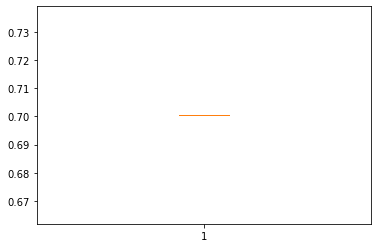

In [47]:
plt.boxplot(similarities)
plt.show()